#  Spectral lines from ionizing and recombining hydrohen plasma


2024.2.2   k.i. \
2024.2.7   k.i., y.h. 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np

#%matplotlib inline
#%matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%load_ext autoreload
%autoreload 2

from spectra_src.ImportAll import *
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', DeprecationWarning)

C:\Users\lelou\AppData\Local\Temp\ipykernel_6356\875321342.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from spectra_src.Struct import Atom, Atmosphere, Radiation
from spectra_src.Atomic import Collision, SEsolver, ContinuumOpacity, BasicP
from spectra_src.Util.HelpUtil import help_
from spectra_src.Visual import Plotting  #, Grotrian
from spectra_src.Atomic import LTELib
from spectra_src.Function.SEquil import SELib
from spectra_src.Atomic import Hydrogen
from spectra_src.Util.AtomUtils.AtomInfo import level_info, extract_lprof, each_prof, line_list
from spectra_src import Constants as Cst
from spectra_src.Function.SlabModel import CloudModel


### Create H-atom

In [3]:
# Atomic model
import os
#conf_path = os.path.join( CFG._ROOT_DIR, "data/conf/H8.conf" )  ; H_nam ='H'
conf_path = os.path.join( CFG._ROOT_DIR, "data/conf/H_theory.conf" )  ; H_nam ='H'
atom, wMesh, path_dict = Atom.init_Atom_(conf_path , is_hydrogen=True)

help_(atom)

------------------------------------------------------------------------------------------
name                       type                                 value/len/shape
------------------------------------------------------------------------------------------
Atom
|- Z                       int                                  v: 1
|- Mass                    float                                v: 1.008
|- Abun                    float                                v: 1.0
|- nLevel                  int                                  v: 21
|- nLine                   int                                  v: 190
|- nCont                   int                                  v: 20
|- nTran                   int                                  v: 210
|- nRL                     int                                  v: 0
|- Level                   struct array                         s: (21,)
  |-  erg                  float64                              s: (21,)
  |-  g                

### $A_{ul} \sim \frac{32 \pi^{3} a_{0}^{2} e^{2} v^{3}}{3 c^{3} \hbar} \sim \frac{R_{y} \alpha^{3}}{\hbar}  \left(\frac{1}{n_{l}^{2}}- \frac{1}{n_{u}^{2}}\right)^{3},  \qquad \alpha = \frac{e^2}{\hbar c}　:  微細構造定数$

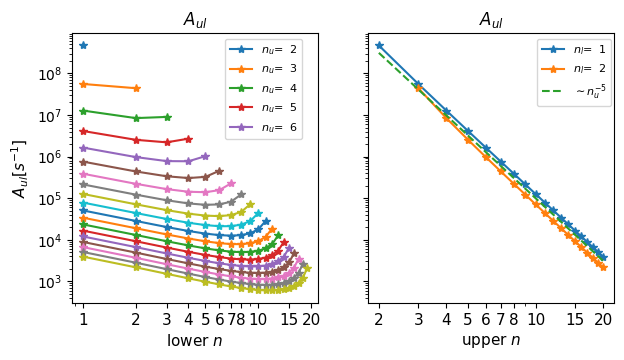

In [4]:
#------- display Aji  -------
Aji = np.array(atom.Line['AJI'])
idxI = np.array(atom.Line['idxI']) # lower level
idxJ = np.array(atom.Line['idxJ']) # upper level
n_lev = np.size(atom.Level)-1
n_line = len(Aji)
nus = np.arange(2,n_lev+1,dtype='int') #  upper n

fig, axs = plt.subplots(1,2, figsize=(7,3.5), dpi=100, sharey=True)

ax=axs[0]  #---  Aji vs. n_l
for n_u in nus:
    ii = np.where((idxI+1 < n_u) & (idxJ+1 == n_u))
    if n_u < 7:
        ax.plot(idxI[ii]+1,Aji[ii],"-*", label="$n_u$={0:3d}".format(n_u))
    else:
        ax.plot(idxI[ii]+1,Aji[ii],"-*")
ax.set_title('$A_{ul}$', fontsize=12)
plt.tick_params(labelsize=11)
ax.set_xscale("log")
ax.set_yscale("log")
ticpos = [1,2,3,4,5,6,7,8,10,15,20]
ticlab = ticpos
ax.set_xticks(ticpos)
ax.set_xticklabels(ticlab, fontsize=11)
ax.set_xlabel("lower $n$", fontsize=11)
ax.set_ylabel("$A_{ul} [s^{-1}]$ ", fontsize=11)
ax.legend(bbox_to_anchor=(0.6,1),fontsize=8,ncol=1)

ax=axs[1]  #---  Aji vs. n_u
for n_l in [1,2]:
    ii = np.where((idxJ+1 > n_l) & (idxI+1 == n_l))
    ax.plot(idxJ[ii]+1,Aji[ii],"-*", label="$n_l$={0:3d}".format(n_l))

ax.plot(nus,1./nus**5 *1e10, '--',label='$\sim n_u^{-5}$')
ax.set_title('$A_{ul}$', fontsize=12)
plt.tick_params(labelsize=11)
ax.set_xscale("log")
ax.set_yscale("log")
ticpos = [2,3,4,5,6,7,8,10,15,20]
ticlab = ticpos
ax.set_xticks(ticpos)
ax.set_xticklabels(ticlab, fontsize=11)
ax.set_xlabel("upper $n$", fontsize=11),
ax.legend(bbox_to_anchor=(1.01,1),fontsize=8,ncol=1)


### $𝐴_{𝑛_𝑢 𝑛_𝑙}=\frac{𝛼𝑅_𝑦}{𝑚𝑐^2}  \frac{2^6}{3\sqrt3} 
\frac{1}{𝜏_{𝑛_𝑢}n_l(𝑛_u^2 − n_l^2)}  𝑔_{𝑏𝑏}$
#### $𝑅_𝑦=\frac{𝑚𝑒^4}{2ℏ^2}, 𝑎_0=\frac{ℏ^2}{𝑚𝑒^2}, 𝛼≡\frac{𝑒^2}{ℏ𝑐}, 𝜏_𝑛=𝑛^3  \frac{ℎ}{2𝑅_𝑦}$
Fujimoto 2004 より


### Solar spectrum array

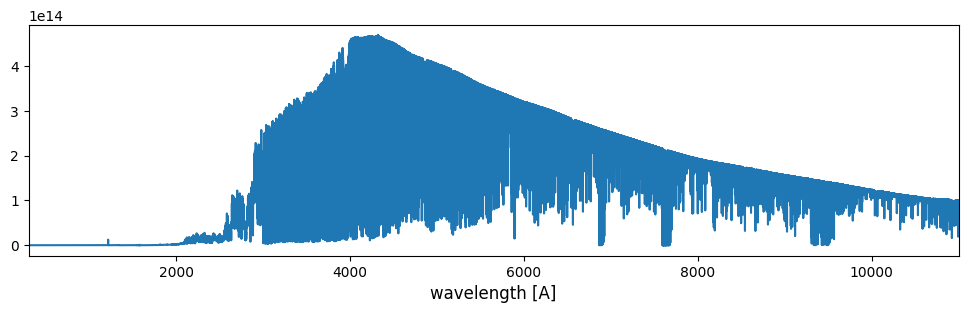

In [5]:
#  prepare solar radiation spectrum
import copy

atmos = Atmosphere.Atmosphere0D(Nh=1.E12, Ne=1.E11, Te=7.E3, Vd=0., Vt=5.E5)
solar_spec  = Radiation.init_Radiation_(atmos, wMesh)
wls = solar_spec.backRad[0,:]*1E8         
wls_air = BasicP.vacuum_to_air_(wls,'AA')   # wavelength in air of background solar spectrum [A]
Isolar = solar_spec.backRad[1,:].copy()   # background solar spectrum intensity    "    [erg/cm^3/s/str]

#  for photo-excitation, mean intensity gets half of the backgroud solar spectrum
solar_spec.backRad[1,:] *= 0.5            # solar spectrum mean intensity    "    [erg/cm^3/s/str]
solar_spec.PI_intensity[:,:] *= 0.5       # solar spectrum mean intensity    "    [erg/cm^3/s/str]

fig, ax = plt.subplots(1,1, figsize=(12,3), dpi=100)
ax.plot(wls_air, Isolar)
ax.set_xlim(300, 11000)
#ax.set_xlim(10820, 10840) ; ax.set_ylim(0,1.2e14)
#ax.set_yscale("log") ; ax.set_ylim(1e7,1e15)
ax.set_xlabel("wavelength [A]", fontsize=12)
plt.show()

### Calculate SE for a given [$T_e,n_e$]

In [6]:
Te = 10000.
Ne = 2*1e10
Vd = 0.
Vt = 5e5          #   cm/s
depth = 1E1* 1.E5 #   km *1e5 -> cm  very thin
Jbar = 1.   # factor for solar radiation

ssp = copy.deepcopy(solar_spec)

slab = Atmosphere.Atmosphere0D(Nh=0, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, use_Tr=False)     # slab 
SE, Rate = SELib.cal_SE_with_Ne_Te_(atom, slab, wMesh, ssp, None)  #  level populations etc.
#help_(slab)
help_(SE)
help_(Rate)
help_(slab)


------------------------------------------------------------------------------------------
name                       type                                 value/len/shape
------------------------------------------------------------------------------------------
SE_Container
|- n_SE                    ndarray                              s: (21,)
|- n_LTE                   ndarray                              s: (21,)
|- nj_by_ni                ndarray                              s: (210,)
|- wave_mesh_shifted_1d    ndarray                              s: (7790,)
|- absorb_prof_1d          ndarray                              s: (7790,)
|- Line_mesh_idxs          ndarray                              s: (190, 2)
|- Jbar                    ndarray                              s: (190,)
|- Ntotal                  float64                              v: 29996669550.605713
|- Nh                      float64                              v: 29996669550.605713
|- Ne                      float 

In [11]:
SE.Ntotal, slab.Nh, SE.Nh, SE.

(29996669550.605713, 29992171224.3591, 29996669550.605713)

## Atomic process
### $\frac{dn_i}{dt}= 
\sum\limits_{j>i}A_{ji}n_j + \sum\limits_{j \ne i} B_{ji} J_\lambda n_j + P_{ci} n_p 
+ \sum\limits_{j \ne i} C_{ji}n_e n_j + C_{ci} n_e n_p \\
\quad -\left[ \sum\limits_{j<i}{A_{ij}} 
+ \sum\limits_{j \ne i} B_{ij} J_\lambda + P_{ic} J_\lambda 
+ \sum\limits_{j\ne i}{C_{ij}} n_e +  C_{ic}  n_e \right]n_i \\
= R_{\nu i} n_\nu + C_{\nu i} n_\nu \qquad [\rm{cm^{-3}s^{-1}, flux}]$
#### $
\begin{bmatrix}
R_{[N,0]} & & & & R_{[N,N]}\\
\vdots & & & & :\\
\vdots & & & & :\\
R_{[1,0]} & R_{[1,1]} & & & :\\
R_{[0,0]} & R_{[0,1]}& & & R_{[0,N]}\\
\end{bmatrix}
=
\begin{bmatrix}
c←1 & \cdots & \rm{電離} & \cdots & 0\\
: & \rm{励起}& & 0 & \vdots \\
: &  &   ／ & & 再結合 \\ 
2←1 & 0 & & \rm{脱励起} & 2←c&\\
0 & 1←2 & & \cdots & 1←c\\
\end{bmatrix}
$ 


In [7]:
# transition heat map
def heatmap(ax, mat,vmin=1e-8, vmax=1e-1, title='', colbar=0):
    
    nmax = len(mat)-1
    norm = LogNorm(vmin, vmax, clip=True)
    im = ax.imshow( mat, origin="lower", cmap='cool', norm=norm, aspect='equal' )
    ax.set_xticks([i for i in range(nmax+1)])
    ax.set_xticklabels([i+1 for i in range(nmax)]+['c'], fontsize=12)
    ax.set_yticks([i for i in range(nmax+1)])
    ax.set_yticklabels([i+1 for i in range(nmax)]+['c'], fontsize=12)
    ax.set_title(title,fontsize=15)

    # colorbar
    if colbar != 0:
        cax = fig.add_axes([0.93, 0.2, 0.02, 0.6])
        fig.colorbar( im, cax=cax, orientation='vertical',label=colbar)
    
    return None


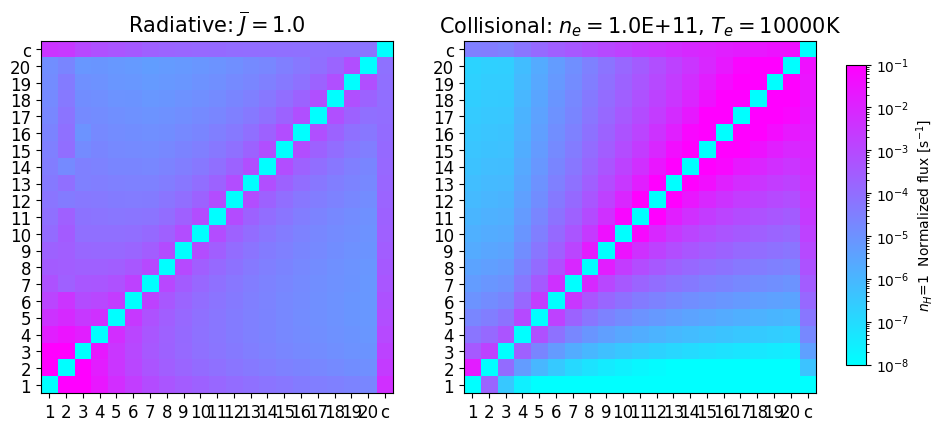

In [8]:
#--- calc. SE & transition flux map ----------------------------------------
Te = 10000.
Ne = 1*1e11
Jbar = 1.   # intensity of solar radiation

ssp = copy.deepcopy(solar_spec)    # solar spectrum mean intensity    "    [erg/cm^3/s/str]
slab = Atmosphere.Atmosphere0D(Nh=0, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, use_Tr=False)     # slab 
SE, Rate = SELib.cal_SE_with_Ne_Te_(atom, slab, wMesh, ssp, None)  #  level populations etc.

vmin = 1e-6 ;  vmax = 1e-2
fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=100)#, sharey=True)
Rmat = Rate.Rmat*SE.n_SE   # [11,11]*[11]
heatmap(axs[0], Rmat, title='Radiative: '+r"$\overline{J}=$"+f"{Jbar:3.1F}")
Cmat = Rate.Cmat*SE.n_SE
heatmap(axs[1], Cmat, title='Collisional: '+r"$n_e=$"+f"{Ne:5.1E}, "+r"$T_e=$"+f"{Te:5.0f}K", 
        colbar='$n_H$=1  Normalized flux [s$^{-1}$]')

plt.show()


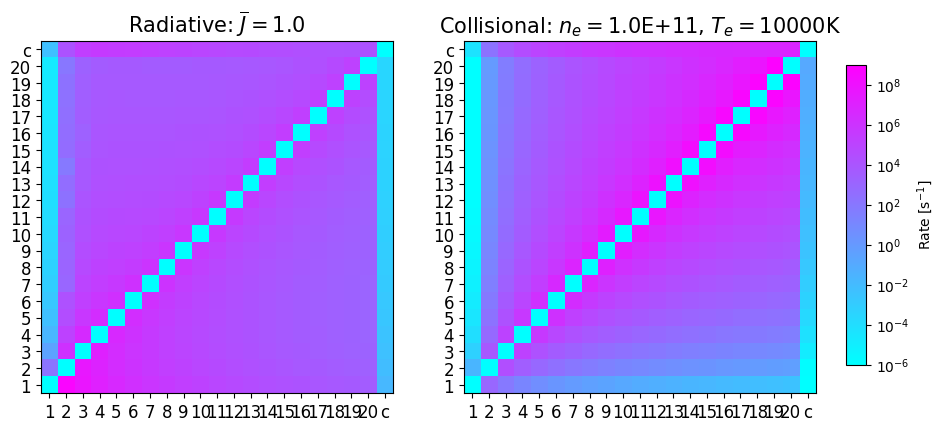

In [9]:
#--- transition rate map ----------------------------------------
vmin = 1e-6 ;  vmax = 1e9

fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=100)#, sharey=True)
title='Radiative: '+r"$\overline{J}=$"+f"{Jbar:3.1F}"
heatmap(axs[0], Rate.Rmat, title=title,vmin=vmin,vmax=vmax)
title='Collisional: '+r"$n_e=$"+f"{Ne:5.1E}, "+r"$T_e=$"+f"{Te:5.0f}K"
heatmap(axs[1], Rate.Cmat, title=title,vmin=vmin,vmax=vmax, colbar='Rate [s$^{-1}$]')

plt.show()


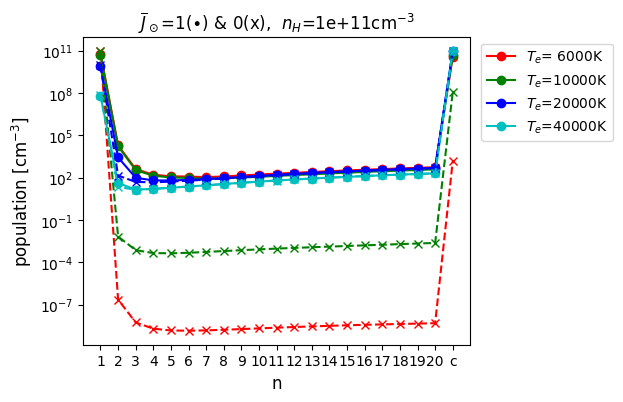

In [10]:
#----- level polulation -----
Nh = 1.E11
Ne = 0.
Jbar = 1.   # intensity of solar radiation
Tes = [6000, 10000, 20000, 40000]

n_lev = np.size(atom.Level)-1
n = np.arange(1,n_lev+2,dtype='int')  # n-array including ion

ssp = copy.deepcopy(solar_spec)    # solar spectrum mean intensity    "    [erg/cm^3/s/str]
tau = np.zeros(n_lev+1)
colors = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=100)

j=0
for Te in Tes:
    slab = Atmosphere.Atmosphere0D(Nh=Nh, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, use_Tr=False)     # slab 
    SE, Rate = SELib.cal_SE_with_Nh_Te_(atom, slab, wMesh, ssp, None)  #  level populations etc.
    ax.plot(n,SE.n_SE*slab.Nh,'-o',label="$T_e$={0:5.0f}K".format(Te), color=colors[j])
    j += 1

Jbar = 0.
ssp = copy.deepcopy(solar_spec)    # solar spectrum mean intensity    "    [erg/cm^3/s/str]
ssp.backRad[1,:] *= 0.5*Jbar     
ssp.PI_intensity[:,:] *= 0.5*Jbar
j=0
for Te in Tes:
    slab = Atmosphere.Atmosphere0D(Nh=Nh, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, use_Tr=False)     # slab 
    SE, Rate = SELib.cal_SE_with_Nh_Te_(atom, slab, wMesh, ssp, None)  #  level populations etc.
    ax.plot(n,SE.n_SE*slab.Nh,'--x'.format(Te), color=colors[j])
    j += 1

ax.set_yscale("log")
ax.set_xticks(n)
ax.set_xticklabels([i for i in n[:-1]]+['c'], fontsize=10)
ax.set_xlabel('n', fontsize=12)
ax.set_ylabel('population [cm$^{-3}$]', fontsize=12)
title = r"$\overline{J}_\odot$=1($\bullet$) & 0(x)"+",  $n_H$={0:5.0e}cm$^{{-3}}$".format(Nh)
plt.title(title,fontsize=12)
ax.legend(bbox_to_anchor=(1.01,1),fontsize=10,ncol=1)

plt.show()

#### Dominant population         $\qquad n_1 + n_p >> \sum\limits_{2\le i\le n_{max}}n_i$

Transitions from $n=1$ and c control the population in levels between them.

### relaxation time
$\frac{dn_i}{dt}=A_i - B_i n_i \quad \rightarrow \quad A_i = B_i n_i^0 \quad$
in statistical eq.
 
$n_i = n_i^0+\Delta n_i \quad 
\rightarrow \frac{dn_i}{dt}=\frac{d\Delta n_i}{dt} = A_i - B_i n_i = -B\Delta n_i
\quad \rightarrow \quad \Delta n_i \propto \exp(-B_i t)$

relaxation time, $\tau_i = 1/B_i = 1/\sum(R[:,i]+C[:,i])$




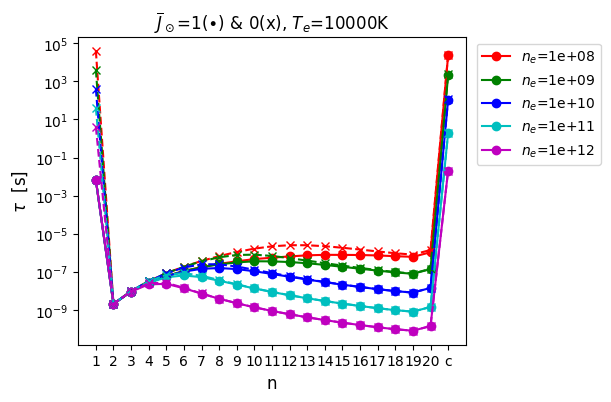

In [11]:
#--- relaxation time vs. n & Ne ----------------------------------------
Te = 10000.
Jbar = 1.   # intensity of solar radiation
Nes = [1E8, 1E9, 1E10, 1E11, 1E12]

ssp = copy.deepcopy(solar_spec)    # solar spectrum mean intensity    "    [erg/cm^3/s/str]
tau = np.zeros(n_lev+1)
colors = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=100)

j=0
for Ne in Nes:
    slab = Atmosphere.Atmosphere0D(Nh=0, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, use_Tr=False)     # slab 
    SE, Rate = SELib.cal_SE_with_Ne_Te_(atom, slab, wMesh, ssp, None)  #  level populations etc.
    for i in range(n_lev+1):
        tau[i] = 1./(Rate.Rmat[:,i].sum()+Rate.Cmat[:,i].sum())
    ax.plot(n,tau,'-o',label="$n_e$={0:3.0e}".format(Ne), color=colors[j])
    j += 1

Jbar = 0.
ssp = copy.deepcopy(solar_spec)    # solar spectrum mean intensity    "    [erg/cm^3/s/str]
ssp.backRad[1,:] *= 0.5*Jbar     
ssp.PI_intensity[:,:] *= 0.5*Jbar
j=0
for Ne in Nes:
    slab = Atmosphere.Atmosphere0D(Nh=0, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, use_Tr=False)     # slab 
    SE, Rate = SELib.cal_SE_with_Ne_Te_(atom, slab, wMesh, ssp, None)  #  level populations etc.
    for i in range(n_lev+1):
        tau[i] = 1./(Rate.Rmat[:,i].sum()+Rate.Cmat[:,i].sum())
    ax.plot(n,tau,'--x',color=colors[j])
    j += 1

ax.set_yscale("log")
ax.set_xticks(n)
ax.set_xticklabels([i for i in n[:-1]]+['c'], fontsize=10)
ax.set_xlabel('n', fontsize=12)
ax.set_ylabel(r"$\tau$  [s]", fontsize=12)
title = r"$\overline{J}_\odot$=1($\bullet$) & 0(x)"+", $T_e$={0:5.0f}K".format(Te)
plt.title(title,fontsize=12)
ax.legend(bbox_to_anchor=(1.01,1),fontsize=10,ncol=1)

plt.show()

### $\tau_1, \tau_c >> \tau_{2\sim N},$ 
=> level population for $n = 2 \sim N$ can be calculated under fixed $n_1$ and $n_p$

at $n_e=10^{10-11}cm^{-3}, \tau_c$ is in order of 10$\sim$100sec regardless of $J_\odot$

### Statistical equiliblium

#### $
\frac{d}{dt}
\begin{bmatrix}
n_1\\
n_2\\
\vdots \\
n_N\\
n_p \\
\end{bmatrix}
=
\begin{bmatrix}
0\\
0\\
\vdots \\
0\\
0 \\
\end{bmatrix}
=
\begin{bmatrix}
T_{11} & T_{12}& \dots & T_{2c} & T_{1c}\\
T_{21} & T_{22} & & T_{2N} & T_{2c} \\
\vdots & & \ddots & & \vdots \\
T_{N1} & T_{N2} & & T_{NN} & T_{Nc}\\
T_{c1} & T_{c2} & \dots & T_{cN} & T_{cc}\\
\end{bmatrix}
\cdot
\begin{bmatrix}
n_1\\
n_2\\
\vdots \\
n_N\\
n_p \\
\end{bmatrix}
\qquad \rm{with} \sum n_i = 1
$
$
T_{i \ne j}= \left( A_{ji} + B_{ji} J_\lambda + C_{ji}n_e \right) n_j \\
T_{ii} = - \sum\limits_{j \ne i}\left( A_{ij} + B_{ij} J_\lambda + C_{ij} n_e \right) n_i
$

### Solving SE with fixed $n_1 \& n_p$ 

#### $
\frac{d}{dt}
\begin{bmatrix}
n_2\\
\vdots \\
n_N\\
\end{bmatrix}
=
\begin{bmatrix}
0\\
\vdots \\
0\\
\end{bmatrix}
=
n_1\begin{bmatrix}
T_{N1}\\
\vdots \\
T_{21}\\
\end{bmatrix}
+
n_p
\begin{bmatrix}
T_{Nc}\\
\vdots \\
T_{2c}\\
\end{bmatrix}
+
\begin{bmatrix}
T_{22} & & T_{2N}\\
 & \ddots &  \\
T_{N2} & & T_{NN}\\
\end{bmatrix}
\cdot
\begin{bmatrix}
n_2\\
\vdots \\
n_N\\
\end{bmatrix}
$ 
すなわち、

$
- n_1\begin{bmatrix}
T_{N1}\\
\vdots \\
T_{21}\\
\end{bmatrix}
-
n_p
\begin{bmatrix}
T_{Nc}\\
\vdots \\
T_{2c}\\
\end{bmatrix}
\equiv
\begin{bmatrix}
V_{N}\\
\vdots \\
V_{2}\\
\end{bmatrix}
=
\begin{bmatrix}
T_{22} & & T_{2N}\\
 & \ddots &  \\
T_{N2} & & T_{NN}\\
\end{bmatrix}
\cdot
\begin{bmatrix}
n_2\\
\vdots \\
n_N\\
\end{bmatrix}
\qquad $ 
を逆行列で解く。



## Level population in ionization non-equiliblium

nArr shape: (19,)
nArr shape: (19,)


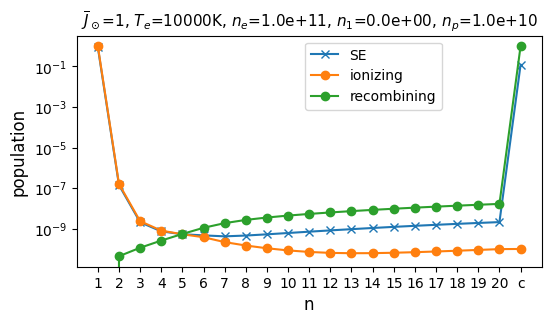

In [12]:
# calculate level population in Non Ionization Equil.
def calc_NIE(atom, slab, wMesh, solar_spec, n1, n_proton):
    ## use rate_only=True to acquire the transition matrix (R matrix and C matrix) without solving linear equation
    SE, Rate = SELib.cal_SE_with_Ne_Te_(atom, slab, wMesh, solar_spec, None, rate_only=True)  #  level populations etc.
    Pmat = SELib.Rmat_Cmat_to_Pmat_(Rate.Rmat, Rate.Cmat)
    # print(f"Pmat has shape: {Pmat.shape}")
    A = Pmat[1:-1,1:-1] ## exclude n=1 level and 
    b = (-n1*Pmat[1:-1,0]-n_proton*Pmat[1:-1,-1])
    ## solve Ax=b
    nArr = np.linalg.solve(A, b) ## population density for levels n=2,3,...,N
    print(f"nArr shape: {nArr.shape}")
    pop = np.zeros(len(nArr)+2)
    pop[0] = n1 ; pop[1:-1] = nArr ; pop[-1] = n_proton
    Ntot = pop.sum()
    SE.n_SE = pop/Ntot

    return(SE,Rate,Ntot)

#----------------------------------------------------------------------
Te = 10000.
Ne = 1.E11
Jbar = 1.   # intensity of solar radiation
#Nes = [1E8, 1E9, 1E10, 1E11, 1E12]
n_lev = np.size(atom.Level)-1
n = np.arange(1,n_lev+2,dtype='int')  # n-array including ion

ssp = copy.deepcopy(solar_spec)    # solar spectrum mean intensity    "    [erg/cm^3/s/str]
ssp.backRad[1,:] *= 0.5*Jbar     
ssp.PI_intensity[:,:] *= 0.5*Jbar  

slab = Atmosphere.Atmosphere0D(Nh=Nh, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, use_Tr=False)     # slab 

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=100)

SE0, Rate = SELib.cal_SE_with_Ne_Te_(atom, slab, wMesh, ssp, None)  #  level populations etc.
ax.plot(n,SE0.n_SE,'-x', label='SE')#, color=colors[j])

n1 = 1.E10  ; n_proton = 1.E0  # cm-3,  ionizing plasma
SE1, Rate1, Ntot1 = calc_NIE(atom, slab, wMesh, ssp, n1, n_proton)
ax.plot(n,SE1.n_SE,'-o', label='ionizing')#, color=colors[j])

n1 = 0.E0  ; n_proton = 1.E10  # cm-3,  ionizing plasma
SE2, Rate2, Ntot2 = calc_NIE(atom, slab, wMesh, ssp, n1, n_proton)
ax.plot(n,SE2.n_SE,'-o', label='recombining')#, color=colors[j])


ax.set_yscale("log")
ax.set_xticks(n)
ax.set_xticklabels([i for i in n[:-1]]+['c'], fontsize=10)
ax.set_xlabel('n', fontsize=12)
ax.set_ylabel("population", fontsize=12)
title = r"$\overline{J}_\odot$="+f"{Jbar:1.0f}, $T_e$=" +f"{Te:5.0f}K, $n_e$="+ \
    f"{Ne:3.1e}, $n_1$="+f"{n1:3.1e}, $n_p$="+f"{n_proton:3.1e}"

ax.legend(bbox_to_anchor=(0.8,1.0),fontsize=10,ncol=1)

plt.title(title,fontsize=11)

plt.show()

#### Line intensity:     $I=A_{ji}N_j h\nu$

In [293]:
help_(SE)

------------------------------------------------------------------------------------------
name                       type                                 value/len/shape
------------------------------------------------------------------------------------------
SE_Container
|- n_SE                    ndarray                              s: (21,)
|- n_LTE                   ndarray                              s: (21,)
|- nj_by_ni                ndarray                              s: (210,)
|- wave_mesh_shifted_1d    ndarray                              s: (7790,)
|- absorb_prof_1d          ndarray                              s: (7790,)
|- Line_mesh_idxs          ndarray                              s: (190, 2)
|- Jbar                    ndarray                              s: (190,)


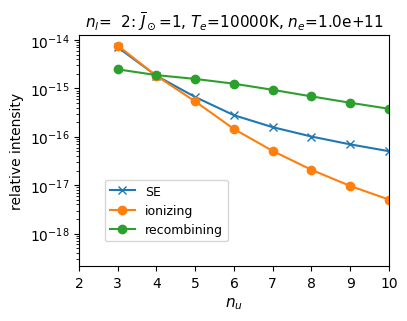

In [291]:
nl = 2
jj = np.where(idxI == nl)
Aji = atom.Line['AJI'][jj]
idxJ = atom.Line['idxJ'][jj]
eps = Cst.h_*Cst.c_/atom.Line['w0'][jj]
n_lev = np.size(atom.Level)-1
n = np.arange(nl,n_lev+1,dtype='int')  # n-array for levels
nmax = 10

fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=100)

Nj0 = SE0.n_SE[idxJ]
ax.plot(idxJ,Aji*Nj0*eps,'-x',label='SE')
Nj1 = SE1.n_SE[idxJ]
ax.plot(idxJ,Aji*Nj1*eps,'-o',label='ionizing')
Nj2 = SE2.n_SE[idxJ]
ax.plot(idxJ,Aji*Nj2*eps,'-o',label='recombining')

ax.set_xlim(nl,nmax)
ax.set_xticks(np.arange(nl,nmax+1))
ax.set_xlabel('$n_u$', fontsize=11)
ax.set_yscale('log')
ax.set_ylabel('relative intensity')
title = r"$n_l$="+f"{nl:3.0f}: "
title = title+r"$\overline{J}_\odot$="+f"{Jbar:1.0f}, $T_e$=" +f"{Te:5.0f}K, $n_e$="+ \
    f"{Ne:3.1e}"
plt.title(title,fontsize=11)

ax.legend(bbox_to_anchor=(0.5,0.4),fontsize=9,ncol=1)

plt.show()


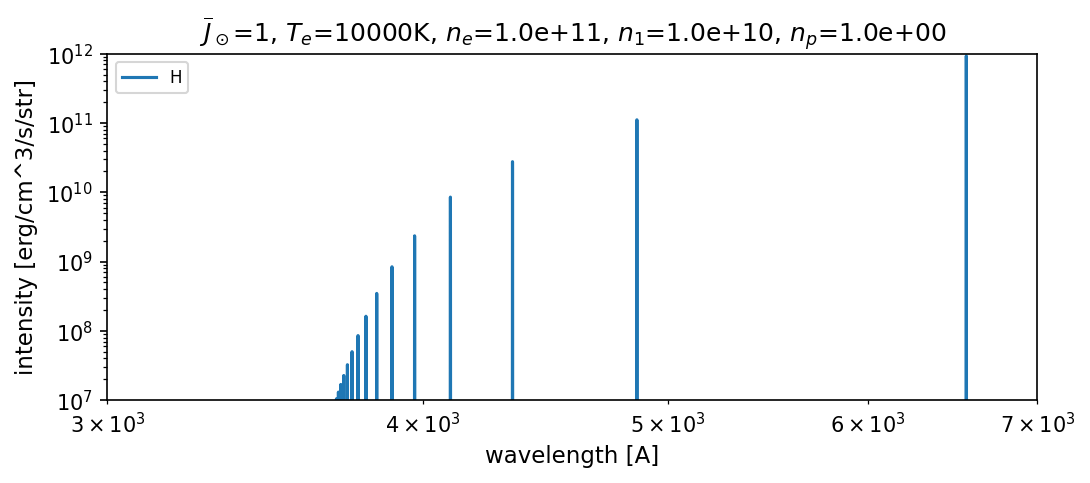

In [139]:
l = CloudModel.SE_to_slab_0D_(atom, slab, SE, depth=depth)      # hydrogen lines intensity

fig, ax = plt.subplots(1,1, figsize=(8,3), dpi=150)
ax.plot(l.wl_1D*1e8,l.prof_1D,label='H')
ax.set_xscale("log")
#ax.set_xlim(0, 20000)
ax.set_xlim(3000, 7000)
ax.set_yscale("log")
ax.set_ylim(1E7,1E12)
ax.set_xlabel("wavelength [A]", fontsize=11)
ax.set_ylabel("intensity [erg/cm^3/s/str]", fontsize=11)
plt.title(title,fontsize=12)
ax.legend(fontsize=8,ncol=1)
plt.show()

## Line intensity

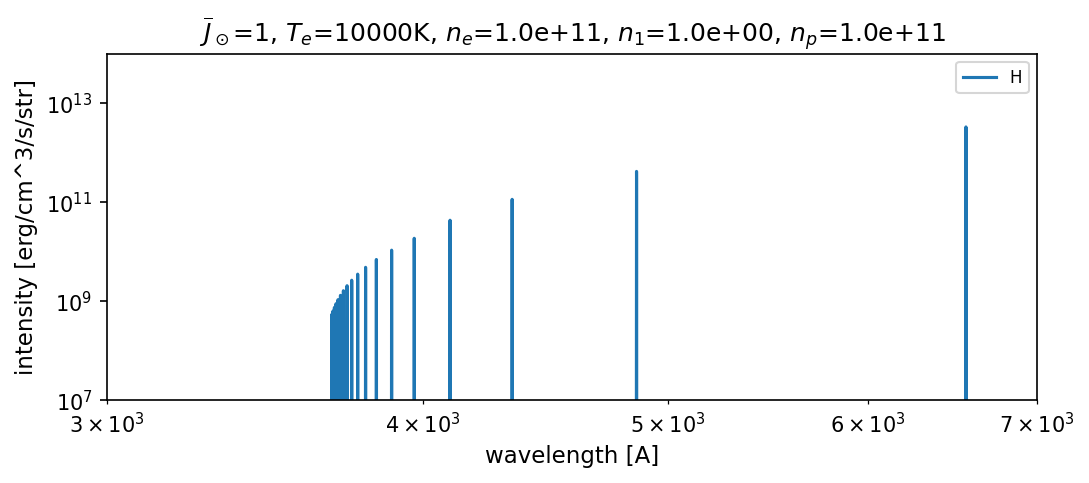

In [93]:
#----- line intensity -----
Te = 10000.
Ne = 1e11
Jbar = 1.   # intensity of solar radiation

ssp = copy.deepcopy(solar_spec)    # solar spectrum mean intensity    "    [erg/cm^3/s/str]
ssp.backRad[1,:] *= 0.5*Jbar     
ssp.PI_intensity[:,:] *= 0.5*Jbar 
slab = Atmosphere.Atmosphere0D(Nh=0, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, use_Tr=False)     # slab 
SE, Rate = SELib.cal_SE_with_Ne_Te_(atom, slab, wMesh, ssp, None)  #  level populations etc.
l = CloudModel.SE_to_slab_0D_(atom, slab, SE, depth=depth)      # hydrogen lines intensity

fig, ax = plt.subplots(1,1, figsize=(8,3), dpi=150)
ax.plot(l.wl_1D*1e8,l.prof_1D,label='H')
ax.set_xscale("log")
#ax.set_xlim(0, 20000)
ax.set_xlim(3000, 7000)
ax.set_yscale("log")
ax.set_ylim(1E7,1E14)
ax.set_xlabel("wavelength [A]", fontsize=11)
ax.set_ylabel("intensity [erg/cm^3/s/str]", fontsize=11)
plt.title(title,fontsize=12)
ax.legend(fontsize=8,ncol=1)
plt.show()

In [349]:
a = np.array([[1,2],[3,4]])
b = np.array([2,3]).reshape(-1,1)
print(a)
print(b)
print(a*b)

[[1 2]
 [3 4]]
[[2]
 [3]]
[[ 2  4]
 [ 9 12]]


In [ ]:
flux  cm^-3 s^-1
rate s^-1  -> relaxsation time


In [47]:
#np.set_printoptions(precision=3,floatmode="fixed",suppress="False") 
np.set_printoptions(precision=10,suppress="False") 
#np.log(Rate.Cmat *SE.n_SE.reshape(1,-1))
Rate.Cmat *SE.n_SE.reshape(1,-1)

array([[0.0000000000, 0.0000229197, 0.0000000187, 0.0000000015,
        0.0000000004, 0.0000000001, 0.0000000001, 0.0000000000,
        0.0000000004],
       [0.0016765116, 0.0000000000, 0.0000066270, 0.0000002959,
        0.0000000611, 0.0000000202, 0.0000000087, 0.0000000049,
        0.0000000371],
       [0.0000359081, 0.0001740715, 0.0000000000, 0.0000131762,
        0.0000014675, 0.0000003786, 0.0000001442, 0.0000000749,
        0.0000003428],
       [0.0000061110, 0.0000164469, 0.0000278792, 0.0000000000,
        0.0000392938, 0.0000051024, 0.0000014803, 0.0000006663,
        0.0000015580],
       [0.0000020592, 0.0000044093, 0.0000040293, 0.0000509896,
        0.0000000000, 0.0001047670, 0.0000143802, 0.0000048303,
        0.0000048367],
       [0.0000009499, 0.0000018137, 0.0000012948, 0.0000082469,
        0.0001304918, 0.0000000000, 0.0002511220, 0.0000380699,
        0.0000118825],
       [0.0000005218, 0.0000009325, 0.0000005858, 0.0000028420,
        0.0000212763, 0.000298

In [33]:
np.set_printoptions(precision=1,floatmode="fixed",suppress="False") 
SE.n_SE.reshape(1,-1)
np.log(Rate.Cmat)

C:\Users\ichim\AppData\Local\Temp\ipykernel_12680\2233984242.py:3: RuntimeWarning: divide by zero encountered in log
  np.log(Rate.Cmat)


array([[ -inf,   5.1,   2.7,   1.1,  -0.1,  -1.0,  -1.8,  -2.5, -21.3],
       [ -5.3,  -inf,   8.5,   6.4,   5.0,   3.9,   3.0,   2.3, -16.7],
       [ -9.2,   7.1,  -inf,  10.2,   8.1,   6.8,   5.8,   5.0, -14.5],
       [-10.9,   4.8,  10.0,  -inf,  11.4,   9.4,   8.2,   7.2, -12.9],
       [-12.0,   3.5,   8.0,  11.5,  -inf,  12.4,  10.4,   9.2, -11.8],
       [-12.8,   2.6,   6.9,   9.7,  12.6,  -inf,  13.3,  11.3, -10.9],
       [-13.4,   1.9,   6.1,   8.6,  10.8,  13.5,  -inf,  14.0, -10.2],
       [-13.9,   1.4,   5.5,   7.9,   9.8,  11.7,  14.2,  -inf,  -9.5],
       [-11.6,   3.5,   7.1,   8.8,   9.9,  10.6,  11.1,  11.6,  -inf]])

## Calc. SE and line profiles for a [$T_e,n_H$]

In [15]:
# import CloudModel from spectra_src.Function.SlabModel

Te = 10000.
Nh = 1*1e11
Ne = 0.
Vd = 0.
Vt = 5e5            #   cm/s
depth = 1E1* 1.E5 #   km *1e5

slab = Atmosphere.Atmosphere0D(Nh=Nh, Ne=Ne, Te=Te, Vd=Vd, Vt=Vt, use_Tr=False)     # slab 
SE, Rate = SELib.cal_SE_with_Nh_Te_(atom, slab, wMesh, solar_spec, None)  #  level populations etc.
l = CloudModel.SE_to_slab_0D_(atom, slab, SE, depth=depth)      # hydrogen lines intensity


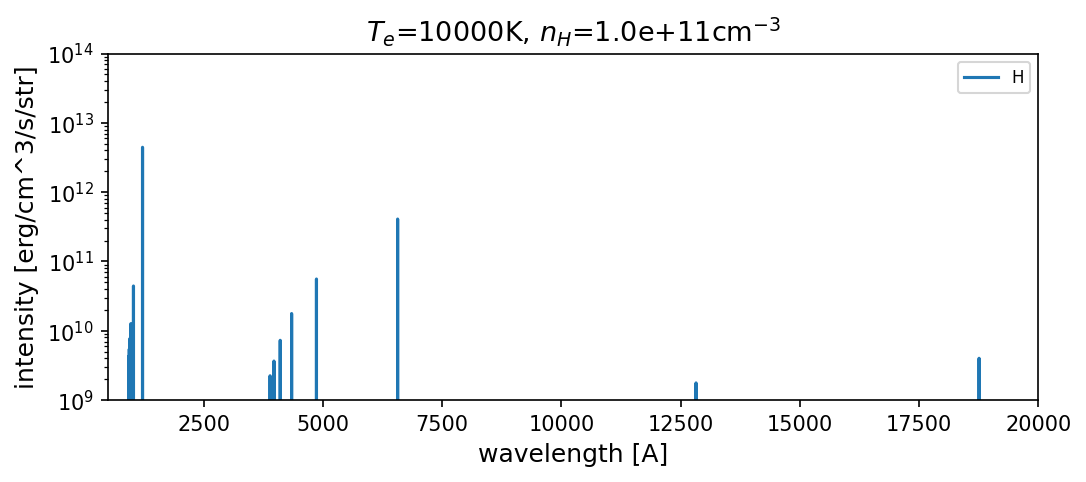

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,3), dpi=150)
ax.plot(l.wl_1D*1e8,l.prof_1D,label='H')
ax.set_ylim(1e9,1E14)
#ax.set_xlim(300, 12000)
#ax.set_xscale("log")
ax.set_xlim(500, 20000)
ax.set_yscale("log")
#ax.set_ylim(1e10, 5e13)
ax.set_xlabel("wavelength [A]", fontsize=12)
ax.set_ylabel("intensity [erg/cm^3/s/str]", fontsize=12)
#plt.title("$T_e$={0:5.0f}K, $n_H$={1:5.1e}cm$^{{-3}}$, $n_e$={2:5.1e}cm$^{{-3}}$".format(Te, Nh, Ne),fontsize=13)
plt.title("$T_e$={0:5.0f}K, $n_H$={1:5.1e}cm$^{{-3}}$".format(Te, Nh),fontsize=13)
ax.legend(fontsize=8,ncol=1)
plt.show()